In [3]:
%load_ext autoreload
%autoreload 2

import os
from utils import set_seed
import torch

set_seed(1234)
os.environ['HF_HOME'] = 'hf_cache' # Don't want model files in our home directory due to disk quota

torch.cuda.is_available()

True

In [4]:
from transformers import LukeTokenizer
import const
from model import DocRedModel
import json

MODEL_NAME = const.LUKE_BASE
MODE = const.MODE_CONTRASTIVE
EPOCHS = 10
ENCODER_LR = const.LRS[MODEL_NAME] # NOTE: LOOK INTO LEARNING RATES
TRAIN_BATCH_SIZE = 3 if MODE == const.MODE_CONTRASTIVE else 4
DEV_BATCH_SIZE = 8
CONTR_TMP = 0.01
 
out_dir = os.path.join('out', 'holdout-batch-0', f"{MODEL_NAME.split('/')[-1]}_{MODE}")

rel2id_original = json.load(open('data/meta/rel2id.json'))
id2rel_original = {v: k for k, v in rel2id_original.items()}
tokenizer = LukeTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True) # Prefix space since we are doing word-level tokenization in read_docred (docred is weird)

/data2/nhanse02/thesis/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
from utils import read_docred
import json

train_samples = read_docred(fp='data/train_annotated.json', rel2id=rel2id_original, tokenizer=tokenizer)
dev_samples = read_docred(fp='data/dev.json', rel2id=rel2id_original, tokenizer=tokenizer)

data/dev.json: 100%|██████████| 998/998 [00:07<00:00, 127.47it/s]


In [6]:
from utils import get_holdouts, remove_holdouts

holdout_rel_batches = get_holdouts(train_samples=train_samples,
                                   dev_samples=dev_samples,
                                   rel2id=rel2id_original,
                                   id2rel=id2rel_original)

holdout_rels = holdout_rel_batches[0]
train_samples, rel2id_holdout, id2rel_holdout = remove_holdouts(samples=train_samples,
                                                                holdout_rels=holdout_rels, # NOTE: only testing with first batch
                                                                rel2id=rel2id_original,
                                                                id2rel=id2rel_original)
holdout_rels

Holdout info file already exists. Loading from file...


['P161', 'P571', 'P166', 'P179', 'P123', 'P577']

In [7]:
from torch.utils.data import DataLoader
from utils import collate_fn
from train import train

train_dataloader = DataLoader(train_samples, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
dev_dataloader = DataLoader(dev_samples, batch_size=DEV_BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False)
val_train_dataloader = DataLoader(train_samples, 
                                  batch_size=dev_dataloader.batch_size,
                                  shuffle=isinstance(dev_dataloader.sampler, torch.utils.data.sampler.RandomSampler), # If sampler is RandomSampler, shuffle=True, else False
                                  collate_fn=collate_fn, 
                                  drop_last=dev_dataloader.drop_last) # (Only used in contrastive) Need new dataloader to validate over training data, i.e. drop_last=False. Want the Dataloader attributes of dev_dataloader just applied to train_samples

In [8]:
# NOTE: If loading models from checkpoint, have to modify the model class depending on the normalization used
model_checkpoint_fp = 'out/holdout-batch-0/luke-base_contrastive-tmp-0.01_new-lr5e5_inprojnorm-plotnorm/checkpoints/best-checkpoint_epoch-5.pt'

model = DocRedModel(model_name=MODEL_NAME,
                    tokenizer=tokenizer,
                    num_class=len(rel2id_holdout),
                    contr_temp=CONTR_TMP).to(const.DEVICE)
model.load_state_dict(torch.load(model_checkpoint_fp, weights_only=True))

<All keys matched successfully>

In [9]:
from train import validate_epoch

embeddings, predictions, labels, labels_original = validate_epoch(model=model,
                                                                  dataloader=val_train_dataloader,
                                                                  mode=MODE)
embeddings.shape

Validation: 100%|██████████| 382/382 [01:58<00:00,  3.23batch/s]


torch.Size([1198650, 768])

In [10]:
# Isolation Forests, OneClassSVM, etc for anomaly detection

from eval_contrastive import contrastive_evaluate

og_stats = contrastive_evaluate(embeddings=embeddings,
                                labels=labels,
                                labels_original=labels_original,
                                id2rel_original=id2rel_original,
                                plot_save_path=None)
og_stats

{'pos_neg_sim': 0.8899170756340027,
 'holdout_cand_ratio': 0.9130269654386631,
 'holdout_cand_count': 2404,
 'holdout_count': 2633,
 'ratio_all_cand_holdout': 0.005095519800248841,
 'neg_cand_ratio': 0.40358458687829685,
 'neg_cand_count': 469383,
 'neg_count': 1163035,
 'ratio_all_cand_neg': 0.9949044801997512,
 'per_class_retain': {'P179': (133.0, 135.0, 0.9851851851851852),
  'P123': (127.0, 128.0, 0.9921875),
  'P166': (150.0, 173.0, 0.8670520231213873),
  'P571': (410.0, 468.0, 0.8760683760683761),
  'P161': (565.0, 605.0, 0.9338842975206612),
  'P577': (1026.0, 1132.0, 0.9063604240282686)}}

In [16]:
from eval import get_masks 

pos_mask, holdout_mask, neg_mask = get_masks(labels, labels_original)

embeddings[pos_mask].shape, embeddings[holdout_mask].shape, embeddings[neg_mask].shape

(torch.Size([32982, 768]), torch.Size([2633, 768]), torch.Size([1163035, 768]))

Dimension Reducing...


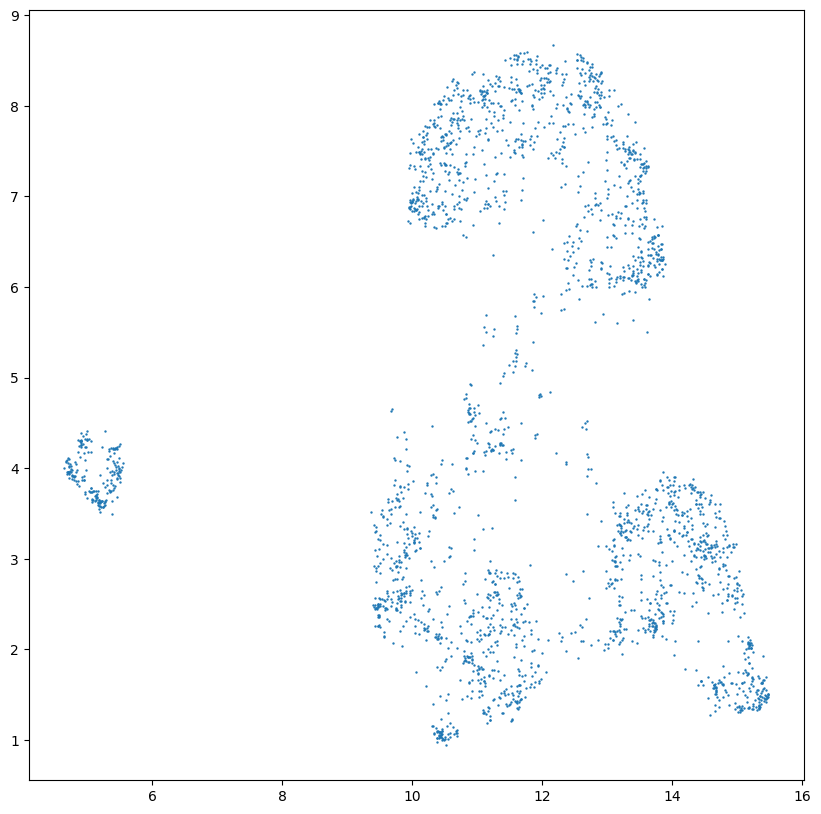

In [15]:
from eval import dim_reduce 
import matplotlib.pyplot as plt

dimred_holdout_embeddings = dim_reduce(embeddings[holdout_mask])

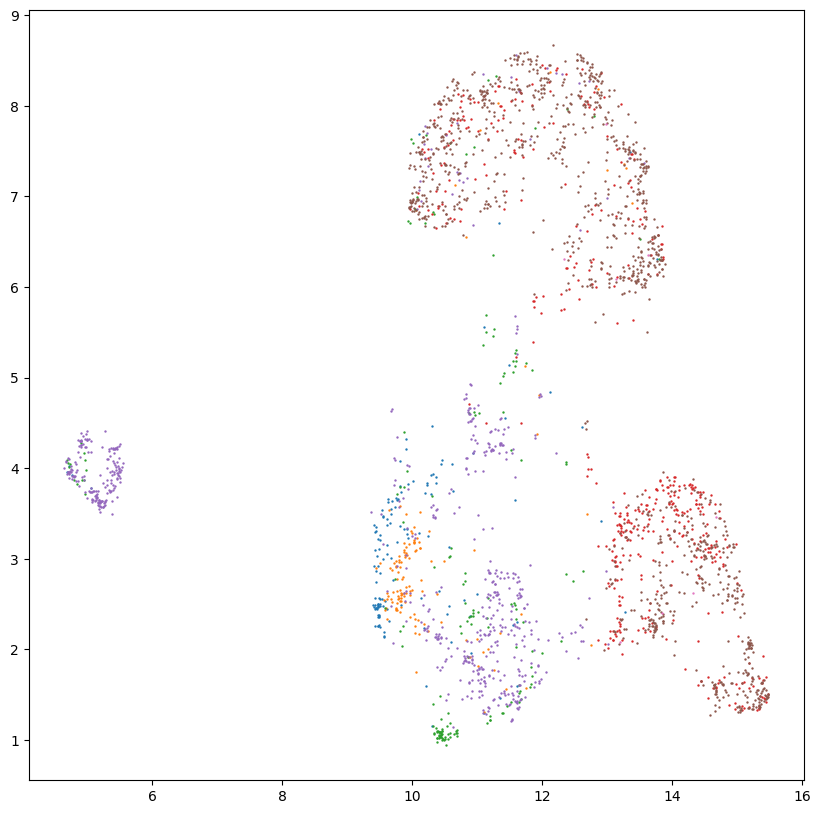

In [23]:
plt.figure(figsize=(10, 10))

for unique_label in labels_original[holdout_mask].unique(dim=0):
    mask = (labels_original[holdout_mask] == unique_label).all(dim=1)
    plt.scatter(dimred_holdout_embeddings[mask][:, 0], dimred_holdout_embeddings[mask][:, 1], s=0.5)
plt.show()